# Interactive Brokers Data Retrieval
This notebook walks through the public API taken from the forecast trader website.
The step to retrieve data include:
- Fetching public auth cookies
- Setting up the WebSocket connection
- Helper function to send and parse requests
- Data Visualization

## Setup:
Install requirements

In [ ]:
!pip install websockets pandas -q

## Import all needed modules (websockets, pandas, json, requests)

In [48]:
import json
import asyncio
import websockets
from datetime import datetime
import requests
import websockets
import pandas as pd

In [49]:
user_agent =  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/127.0.0.0 Safari/537.36"
s = requests.Session()
s.headers["User-Agent"] = user_agent
s.get("https://forecasttrader.interactivebrokers.com/eventtrader/#/market-details?market=g2&id=658663572202409184.8751&detail=contract_details")
s.get("https://forecasttrader.interactivebrokers.com/portal.proxy/v1/etp/iserver/auth/status")
cookie_string = "; ".join([f"{name}={value}" for name, value in s.cookies.items()])

# Helper functions for data processing
- Mapping data fields
- Helper functions for the websocket

In [50]:

map_keys = {
    # added manually:
    "87_raw": "volume_raw",
    # automatically converted:
    "31": "last_price",
    "55": "symbol",
    "58": "text",
    "70": "high",
    "71": "low",
    "72": "position",
    "73": "market_value",
    "74": "avg_price",
    "75": "unrealized_pnl",
    "76": "formatted_position",
    "77": "formatted_unrealized_pnl",
    "78": "daily_pnl",
    "82": "change",
    "83": "change_percent",
    "84": "bid_price",
    "85": "ask_size",
    "86": "ask_price",
    "87": "volume",
    "88": "bid_size",
    "6004": "exchange",
    "6008": "conid",
    "6070": "sec_type",
    "6072": "months",
    "6073": "regular_expiry",
    "6119": "marker",
    "6457": "underlying_contract",
    "6509": "market_data_availability",
    "7051": "company_name",
    "7057": "ask_exch",
    "7058": "last_exch",
    "7059": "last_size",
    "7068": "bid_exch",
    "7084": "market_data_availability_other",
    "7085": "put_call_interest",
    "7086": "put_call_volume",
    "7087": "historic_volume_percent",
    "7088": "historic_volume_close_percent",
    "7089": "option_volume",
    "7094": "contract_id_and_exchange",
    "7219": "contract_description",
    "7220": "contract_description_other",
    "7221": "listing_exchange",
    "7280": "industry",
    "7281": "category",
    "7282": "average_volume",
    "7283": "option_implied_volatility_percent",
    "7284": "historic_volume",
    "7285": "put_call_ratio",
    "7286": "dividend_amount",
    "7287": "divident_yield",
    "7288": "ex",
    "7289": "market_cap",
    "7290": "price_earnings_ratio",
    "7291": "earnings_per_share",
    "7292": "cost_basis",
    "7293": "fifty_two_week_low",
    "7294": "fifty_two_week_high",
    "7295": "open",
    "7296": "close",
    "7308": "delta",
    "7309": "gamma",
    "7310": "theta",
    "7311": "vega",
    "7607": "option_volume_change_percent",
    "7633": "implied_volatility_percent",
    "7635": "mark",
    "7636": "shortable_shares",
    "7637": "fee_rate",
    "7638": "option_open_interest",
    "7639": "percent_of_market_value",
    "7644": "shortable",
    "7655": "morningstar_rating",
    "7671": "dividends",
    "7672": "dividends_ttm",
    "7674": "ema_two_hundred",
    "7675": "ema_one_hundred",
    "7676": "ema_fifty_day",
    "7677": "ema_twenty_day",
    "7678": "price_ema_two_hundred_day",
    "7679": "price_ema_one_hundred_day",
    "7680": "price_ema_fifty_day",
    "7681": "price_ema_twenty_day",
    "7682": "change_since_open",
    "7683": "upcoming_event",
    "7684": "upcoming_event_date",
    "7685": "upcoming_analyst_meeting",
    "7686": "upcoming_earnings",
    "7687": "upcoming_misc_events",
    "7688": "recent_analyst_meeting",
    "7689": "recent_earnings",
    "7690": "recent_misc_events",
    "7694": "probability_of_max_return_customer",
    "7695": "break_even",
    "7696": "spx_delta",
    "7697": "futures_open_interest",
    "7698": "last_yield",
    "7699": "bid_yield",
    "7700": "probability_max_return",
    "7702": "probability_max_loss",
    "7703": "profit_probability",
    "7704": "organization_type",
    "7705": "debt_class",
    "7706": "ratings",
    "7707": "bond_state_code",
    "7708": "bond_type",
    "7714": "last_trading_date",
    "7715": "issue_date",
    "7718": "beta",
    "7720": "ask_yield",
    "7741": "prior_close",
    "7762": "volume_long"
}


def get_chart(conId:int,period="7d",bar="1min"):
    global msgId
    id = msgId
    msgId+=1
    conId=str(conId)
    # hdr+712856939+{"period":"1w","bar":"5min","outsideRth":true,"requestId":0}
    return "hdr+"+ str(conId)  + "+" + json.dumps({"period":"1w","bar":"5min","outsideRth":True,"requestId":msgId})

def get_ticker(conId:int):
    conId=str(conId)
    return 'smd+'+conId+'+{"fields":["87_raw", "31", "55", "58", "70", "71", "72", "73", "74", "75", "76", "77", "78", "82", "83", "84", "85", "86", "87", "88", "6004", "6008", "6070", "6072", "6073", "6119", "6457", "6509", "7051", "7057", "7058", "7059", "7068", "7084", "7085", "7086", "7087", "7088", "7089", "7094", "7219", "7220", "7221", "7280", "7281", "7282", "7283", "7284", "7285", "7286", "7287", "7288", "7289", "7290", "7291", "7292", "7293", "7294", "7295", "7296", "7308", "7309", "7310", "7311", "7607", "7633", "7635", "7636", "7637", "7638", "7639", "7644", "7655", "7671", "7672", "7674", "7675", "7676", "7677", "7678", "7679", "7680", "7681", "7682", "7683", "7684", "7685", "7686", "7687", "7688", "7689", "7690", "7694", "7695", "7696", "7697", "7698", "7699", "7700", "7702", "7703", "7704", "7705", "7706", "7707", "7708", "7714", "7715", "7718", "7720", "7741", "7762"],"backout":true}'


def load_json(m):
    t = m.decode('utf-8')
    if t[0]!= "e":
        return json.loads(t)
    return {}



# Real-time Market Data Streaming
- Authentification
- Fetching ticker information
- Handling chart data
## Note: This will run forever until stopped

In [55]:
# Setting up our storage for charts and historic messages

msgId = 1
msgs = []
charts = {}

In [57]:
wss = 'wss://forecasttrader.interactivebrokers.com/portal.proxy/v1/etp/ws'

async with websockets.connect(wss,
                              extra_headers={'User-Agent': user_agent, "cookie": cookie_string}
                              ) as websocket:
    # Handle the WebSocket connection here
    # For example, receive a message
    m = await websocket.recv()
    print(m)
    await websocket.send("system")
    m = await websocket.recv()
    print(m)
    m = await websocket.recv()
    print(m)
    await websocket.recv()
    tickers = [721095500,721095497]
    for ticker in tickers:
        await websocket.send(get_chart(ticker))
        m = await websocket.recv()
        d = load_json(m)
        charts[ticker] = d
        print(d)
    for ticker in tickers:
        await websocket.send(get_ticker(ticker))

    while True:
        m = await websocket.recv()
        d = load_json(m)
        if d.get("hb"):
            await websocket.send("ech+hb")
        else:
            msgs.append(d)

b'{"topic":"system","success":"mdtst0166","isFT":false,"isPaper":true}'
b'{"topic":"sts","args":{"authenticated":true,"competing":false,"message":"","fail":"","serverName":"JisfN5089","serverVersion":"Build 10.29.0m, Jul 22, 2024 6:00:04 PM","username":"mdtst0166"}}'
b'{"topic":"act","args":{"accounts":["DU2629695"],"acctProps":{"DU2629695":{"hasChildAccounts":false,"supportsCashQty":true,"liteUnderPro":false,"noFXConv":false,"isProp":false,"supportsFractions":true,"allowCustomerTime":false}},"aliases":{"DU2629695":"DU2629695"},"allowFeatures":{"showGFIS":true,"showEUCostReport":false,"allowEventContract":true,"allowFXConv":true,"allowFinancialLens":false,"allowMTA":true,"allowTypeAhead":true,"allowEventTrading":true,"snapshotRefreshTimeout":30,"liteUser":false,"showWebNews":true,"research":true,"debugPnl":true,"showTaxOpt":true,"showImpactDashboard":true,"allowDynAccount":false,"allowCrypto":false,"allowFA":false,"allowLiteUnderPro":false,"allowedAssetTypes":"STK,CFD,OPT,FOP,WAR,FUT,B

CancelledError: 

# Data Processing and Visualization

- Converting timestamps
- Plotting opening prices

<Axes: >

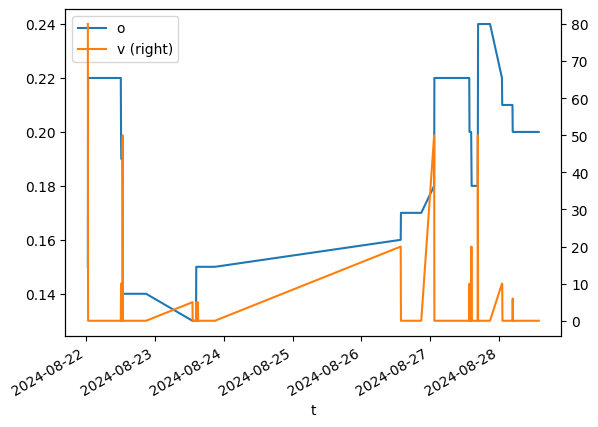

In [58]:
df = pd.DataFrame(charts[721095500]["data"])
df["t"] = pd.to_datetime(df["t"]*10**6)
ax = df.plot(x="t",y="o")
df.plot(x="t",y="v", secondary_y=True,ax=ax)